# aSPEM Experiment : analysis



TODO: clean-up garder blocs indep full R

TODO: moulinette statistique ? https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test https://en.wikipedia.org/wiki/Earth_mover%27s_distance

TODO: https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot

TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
import pickle
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

## find best h

In [5]:
def best_h(exp, max_tau) :

    # see notebook dev/2019_07_10_test_harzardrate
    def pred_score(o, p_hat):
        score = o * np.log2(p_hat) + (1-o) * np.log2(1-p_hat)
        return score

    best_h = []
    
    N_blocks = exp['N_blocks']
    p = exp['p']
    tau = np.arange(1, max_tau, 1)
    hs = 1/tau
    
    for i_block in range(N_blocks):
        score = []
        
        o = p[:, i_block, 0] # observations
        p_true = p[:, i_block, 1]

        for i_scan, h_ in enumerate(hs):

            p_hat = np.zeros(200)

            liste = [0, 50, 100, 150, 200]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(o[liste[a]:liste[a+1]], h=h_)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean')

                p_hat[liste[a]:liste[a+1]] = p_hat_p

            score.append(np.mean(pred_score(o, p_hat)))
        
        best_h.append(hs[np.argmax(score)])
        
    return best_h

In [6]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [7]:
def maxx_pourcentage(r_, pourcentage) :
    maxx=None
    for round_ in list(reversed(np.arange(5))) :
        if maxx is None :
            for x in range(len(r_)) :
                if np.round(r_[x], round_)==np.round(pourcentage*np.max(r_), round_) :
                    maxx=x
    return maxx

In [8]:
def print_stat(h) :
    from scipy import stats
    
    print('\n\t\t\tmannwhitneyu', '\tkruskal', '\t\tks_2samp', sep='')
    print('\t\t\t','-'*12, '\t', '-'*7, '\t\t', '-'*8, sep='')
    
    def stata(h1, h2) :
        man = stats.mannwhitneyu(h1, h2).pvalue
        kr = stats.kruskal(h1, h2).pvalue
        ks = stats.ks_2samp(h1, h2).pvalue
        print('%.4f'%man, '%.4f'%kr, '%.4f'%ks, sep='\t\t')
              #'\nwasserstein_distance (Earth movers distance) : ',
              #stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
        return man, kr, ks
    
    list_signi = []
    for b1 in range(2) :
        for b2 in range(1, 3) :
            if b1!=b2 :
                print('BLOCK %s vs %s'%(b1,b2), end=' :\t\t')
                man, kr, ks = stata(h['b'][b1], h['b'][b2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('B %s-%s'%(b1,b2)) ; break
    print('\nSignificatif :', list_signi)

In [9]:
suj = ['AM', 'BMC', 'CS', 'DC', 'FM', 'IP', 'LB', 'OP', 'RS', 'SR',  'TN', 'YK']

In [10]:
fig_width_f = fig_width/2
def plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None, ls=None, v_line_supp=None) :
    
    from matplotlib.patches import Polygon
    
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:max_tau]
    #COLOR = ['b', 'r', 'k', 'g', 'm', 'c', 'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']
    c_block = ['olive', 'peru', 'brown']
    
    
    fig = plt.figure(figsize=(fig_width_f,fig_width_f))
    import matplotlib.gridspec as gridspec

    gs = gridspec.GridSpec(5, 5, figure=fig, left=0.1, bottom=0.1, right=1, top=1,
                           wspace=0.1, hspace=0.1)
    ax_ = plt.subplot(gs[1:, :4])
    ax_xC, ax_yC  = plt.subplot(gs[0, :4]), plt.subplot(gs[1:, 4])
    
    
    # DECO
    #---------------------------------------------------------------
    lim = (min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    ax_x, ax_y = ax_xC.twinx(), ax_yC.twiny()
    
    lim = (np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
    for a in [ax_x, ax_xC] : a.set_xlim(lim) ; a.set_xticks(())
    for a in [ax_y, ax_yC] : a.set_ylim(lim) ; a.set_yticks(())
    
    ax_xC.set_ylim(0,1.05); ax_yC.set_xlim(0,1.05)
    
    # LABEL
    ax_.set_xlabel('h$_{va}$', fontsize=t_label) ; ax_.set_ylabel('h$_{bet}$', labelpad=-20, fontsize=t_label)
    opt = dict(fontsize=t_label/2.7)
    
    
    ax_xC.set_ylabel('cumulative', **opt)
    ax_yC.set_xlabel('cumulative', **opt) 
    opt['color'] = 'dimgrey'
    ax_x.set_ylabel('density of h$_{va}$', va='bottom', rotation=270, **opt)
    ax_y.set_xlabel('density of h$_{bet}$', va='bottom', **opt) 
    
    for a in [ax_, ax_x, ax_xC, ax_y, ax_yC] : a.set_title('', fontsize=0)
    
    # tick
    ax_.tick_params(labelsize=t_label/2.7, length=7, which='major') ; ax_.tick_params(length=5, which='minor')
    
    opt = dict(labelsize=t_label/2.7)
    for a in [ax_x, ax_xC, ax_y, ax_yC] : a.tick_params(**opt)
    ax_x.set_yticks(())                    ; ax_y.set_xticks(())
    ax_xC.set_yticks((0,0.5,1))            ; ax_yC.set_xticks((0,0.5,1))
    ax_xC.set_yticklabels(('0','0.5','1')) ; ax_yC.set_xticklabels(('0','0.5','1'))
    
    #---------------------------------------------------------------
    h_va, h_bet, r_va, r_bet = {}, {}, {}, {}
    for l in [h_va, h_bet, r_va, r_bet] : l['full'], l['b'] = [], [[],[],[]]
        
    #---------------------------------------------------------------
    for num, s in enumerate(suj) :
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :
            r_va_d, r_bet_d = recording['r_va'][s][d][:max_tau], recording['r_bet'][s][d][:max_tau]

            if pourcentage is not None :
                #pourcentage
                #-----------------------------------------------------------------------
                if np.argmax(r_va_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_va_d, pourcentage)
                    r_va_s.append(r_va_d[maxx]) ; h_va_s.append(list_h[maxx])
                else : r_va_s.append(np.max(r_va_d)) ; h_va_s.append(list_h[np.argmax(r_va_d)])

                if np.argmax(r_bet_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_bet_d, pourcentage)
                    r_bet_s.append(r_bet_d[maxx])   ; h_bet_s.append(list_h[maxx])
                else : r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                #-----------------------------------------------------------------------
            else :
                r_va_s.append(np.max(r_va_d))   ; h_va_s.append(list_h[np.argmax(r_va_d)])
                r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                
            h_va['b'][d].append(h_va_s[d]) ; h_bet['b'][d].append(h_bet_s[d])
            r_va['b'][d].append(r_va_s[d]) ; r_bet['b'][d].append(r_bet_s[d])
        
        #-----------------------------------------------------------------------
        # TRIANGLE
        tritri = np.array([[h_va_s[y], h_bet_s[y]] for y in range(len(h_va_s))])
        popo = Polygon(tritri, edgecolor='k', alpha=0.4, lw=1,
                       ls=ls[num] if ls is not None else '-', facecolor='none') # color=COLOR[num]  
        ax_.add_artist(popo)
        
        #-----------------------------------------------------------------------           
        opt = dict(alpha=0.6, lw=0, edgecolors='k') # c=COLOR[num], lw=3
        if s in ['TN', 'LB'] :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*1000,
                        marker='*', c=c_block[:1], zorder=100, lw=0.2, edgecolors='k')
        else :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*600,
                        c=c_block[:1], zorder=50, **opt)

        ax_.scatter(h_va_s[1:], h_bet_s[1:], s=(np.array(r_va_s[1:])*np.array(r_bet_s[1:]))*600,
                    c=c_block[1:], zorder=50, **opt)
        
        #-----------------------------------------------------------------------
        h_va['full'].extend(h_va_s) ; h_bet['full'].extend(h_bet_s)
        r_va['full'].extend(r_va_s) ; r_bet['full'].extend(r_bet_s)
    
    h_va['full'], h_bet['full'], r_va['full'], r_bet['full'] = mask_nan(h_va['full'], h_bet['full'], r_va['full'], r_bet['full'])
    r_va['full'], r_bet['full'] = np.array(r_va['full']), np.array(r_bet['full'])

    #--------------------------------------------------------------------------------------------
    # HISTOGRAMME
    #--------------------------------------------------------------------------------------------
    opt = dict(range=(np.log(min(list_h)), np.log(max(list_h))), bins=20)#, alpha=0.3)
    opt_c = dict(range=(np.log(min(list_h)-min(list_h)/9), np.log(max(list_h)+max(list_h)/9)),
                 bins=len(list_h), cumulative=True, histtype='step', align='mid', lw=2, density=True)
    
    # hist VA
    #--------------------------------------------------------------------
    for a, o, c in zip([ax_x, ax_xC], [opt, opt_c], ['dimgrey', 'k']) :
        a.hist(np.log(h_va['full']), color=c, label='Full', alpha=0.3 if o==opt else 1, **o) # weights=r_va['full']
        a.hist([np.log(h_va['b'][0]), np.log(h_va['b'][1]), np.log(h_va['b'][2])],
               color=c_block, label=['block 1', 'block 2', 'block 3'],
               alpha=0.6 if o==opt else 1, **o) # weights=[r_va['b'][0], r_va['b'][1], r_va['b'][2]]
    # hist BET
    #--------------------------------------------------------------------
    opt['orientation'], opt_c['orientation'] = "horizontal", "horizontal"
    for a, o, c in zip([ax_y, ax_yC], [opt, opt_c], ['dimgrey', 'k']) :
        a.hist(np.log(h_bet['full']), color=c, label='Full', alpha=0.3 if o==opt else 1, **o) # weights=r_bet['full']
        a.hist([np.log(h_bet['b'][0]), np.log(h_bet['b'][1]), np.log(h_bet['b'][2])],
               color=c_block, label=['block 1', 'block 2', 'block 3'],
               alpha=0.6 if o==opt else 1, **o) # weights=[r_bet['b'][0], r_bet['b'][1], r_bet['b'][2]]
    
    # lines
    #--------------------------------------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '-k', alpha=0.5, lw=1.5)
    opt=dict(colors='teal', linestyles='-', alpha=0.7, linewidth=1.5)
    ax_.vlines(0.025, -10, 10, label='h$_{true}$', **opt) ; ax_.hlines(0.025, -10, 10, **opt)
    ax_xC.vlines(np.log(0.025), 0, 1.1, **opt) ; ax_yC.hlines(np.log(0.025), 0, 1.1, **opt)
    
    lim = [np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10)]
    ax_xC.hlines(0.5, lim[1], lim[0], colors='k', alpha=0.5, linewidth=1)
    ax_yC.vlines(0.5, lim[1], lim[0], colors='k', alpha=0.5, linewidth=1)
    
    
    
    opt_legend = dict(alpha=0.7, lw=15, colors='k')
    ax_.vlines(0, 0, 0, label='Full', **opt_legend)
    
    mimi_va, mimi_bet = np.nanmedian(h_va['full']), np.nanmedian(h_bet['full'])
    
    
    opt=dict(colors='k', alpha=0.8, lw=1.5, linestyles=(3.5,[4, 2, 4, 2]))
    ax_.vlines(mimi_va, 0, 10, **opt) ; ax_.hlines(mimi_bet, 0, 10, **opt)
    ax_xC.vlines(np.log(mimi_va), 0, 1.1, **opt) ; ax_yC.hlines(np.log(mimi_bet), 0, 1.1, **opt)
    
    for b, c in enumerate(c_block) :
        opt['colors'] = c
        opt_legend['colors'] = c
        mimi_va, mimi_bet = np.nanmedian(h_va['b'][b]), np.nanmedian(h_bet['b'][b])
        
        print('\nBLOCK %s'%(b), end=' :\t\t')
        print('\nVA\tmedian', np.nanmedian(h_va['b'][b]),
              #'\t25%', np.quantile(h_va['b'][b], 0.25),
              #'\t75%', np.quantile(h_va['b'][b], 0.75),
             '\nBET\tmedian', np.nanmedian(h_bet['b'][b]),
              #'\t25%', np.quantile(h_bet['b'][b], 0.25),
              #'\t75%', np.quantile(h_bet['b'][b], 0.75)
             )
        
        ax_.vlines(mimi_va, 0, 10, **opt) ; ax_.hlines(mimi_bet, 0, 10, **opt)
        ax_xC.vlines(np.log(mimi_va), 0, 1.1, **opt) ; ax_yC.hlines(np.log(mimi_bet), 0, 1.1, **opt)
        
        ax_.vlines(0, 0, 0, label='block %s'%(b+1), **opt_legend)
    
    if v_line_supp is not None :
        opt=dict(alpha=0.8, lw=1.5)
        
        for i, l in enumerate(v_line_supp['lines']) :
            opt['colors'] = v_line_supp['colors'][i]
            ax_.vlines(l, 0, 10, **opt) ; ax_.hlines(l, 0, 10, **opt)
            ax_xC.vlines(np.log(l), 0, 1.1, **opt) ; ax_yC.hlines(np.log(l), 0, 1.1, **opt)
    #--------------------------------------------------------------------
    # Legend
    opt_l = dict(fontsize=t_label/2.7, framealpha=0)#, handlelength=0.6, handletextpad=0.2)
    #ax_x.legend(loc='lower left', bbox_to_anchor=(0.03, -1.04, 0., 0.) ,**opt_l)
    ax_.legend(loc=2, bbox_to_anchor=(0.05, 0.95, 0., 0.) ,**opt_l)
    #--------------------------------------------------------------------------------------------
    #gs.tight_layout(fig)
    plt.show()
    
    #--------------------------------------------------------------------------------------------
    # STAT
    #--------------------------------------------------------------------------------------------
    from scipy import stats
    print('h_va/h_bet :', stats.wilcoxon(h_va['full'], h_bet['full']))
    _, _, r, _, _ = stats.linregress(h_va['full'], h_bet['full'])
    print('h_va/h_bet : r =', r)
    
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], ['h_va', 'h_bet']) :
        print('\n\n', '-'*64,'\n%s\n'%title, '-'*64, sep='')        
        h['full'] = list(h['full'])
        print('median', np.nanmedian(h['full']),
              '\n25%', np.quantile(h['full'], 0.25),
              '\n75%', np.quantile(h['full'], 0.75))
        print_stat(h)
    #--------------------------------------------------------------------------------------------
    
    return fig

In [11]:
file = os.path.join('parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier : recording = pickle.load(fichier, encoding='latin1')

In [12]:
max_tau=1601

In [13]:
import glob
import pickle
for fname in glob.glob('data/pari*pkl'):
    l = fname.split('/')[1].split('.')[0].split('_')
    if l[1]=='AM' :
        a = 'data/pari_AM_%s.pkl'%(l[2]+'_'+l[3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp = b

v_line_supp = {}
v_line_supp['colors'] = ['olive', 'peru', 'brown']
v_line_supp['lines'] = best_h(exp, max_tau)

In [14]:
ls =   [(0,[3*i,2,3*i,2]) for i in range(1, 13)]
opt = dict(max_tau=max_tau, ls=ls)

In [15]:
print(v_line_supp['lines'])

[0.05555555555555555, 0.041666666666666664, 0.07692307692307693]


AM BMC CS DC FM IP LB OP RS SR TN YK 
BLOCK 0 :		
VA	median 0.05714285714285714 
BET	median 0.017427884615384616

BLOCK 1 :		
VA	median 0.05263157894736842 
BET	median 0.026334026334026334

BLOCK 2 :		
VA	median 0.09545454545454546 
BET	median 0.0393939393939394


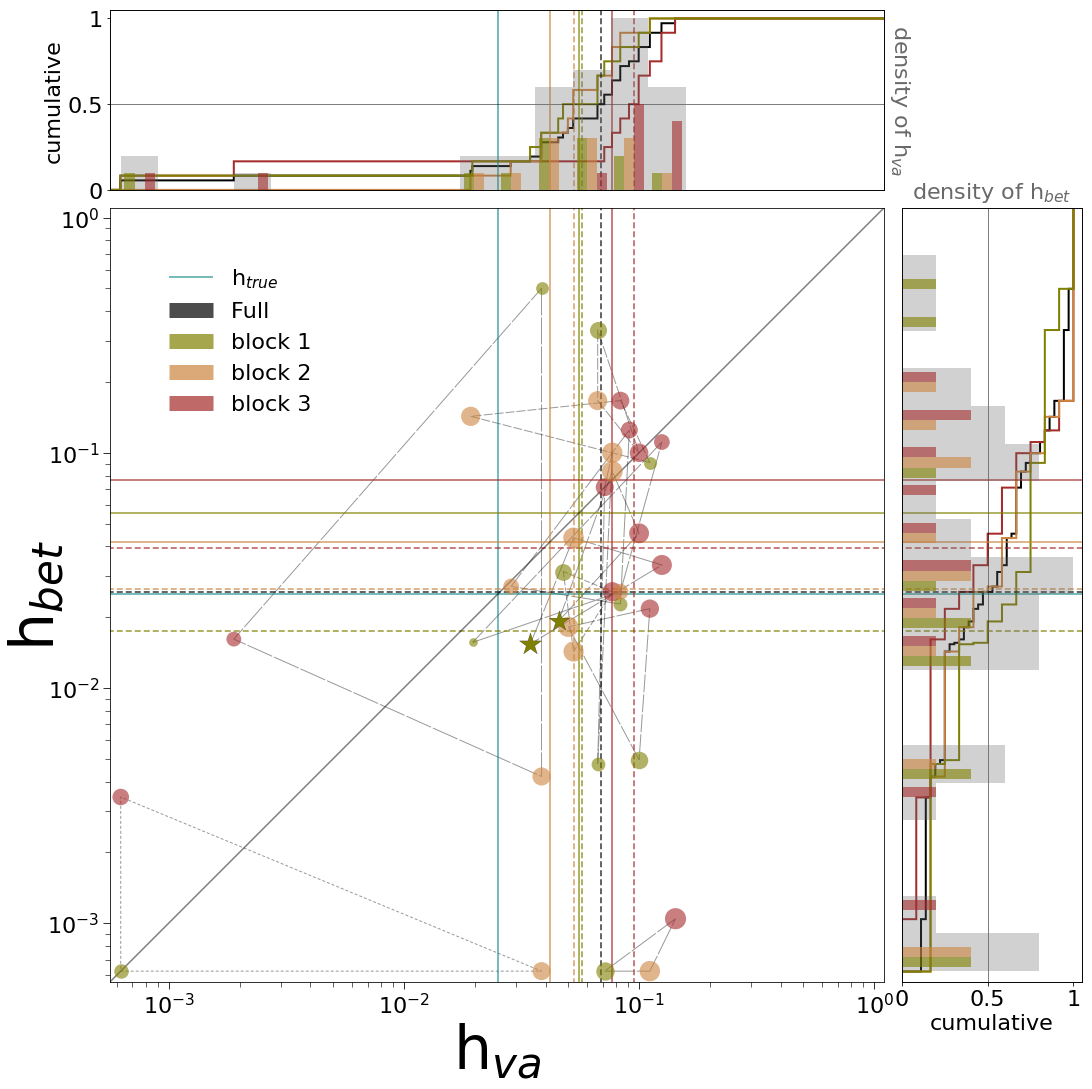

h_va/h_bet : WilcoxonResult(statistic=185.0, pvalue=0.08793778289576284)
h_va/h_bet : r = 0.0024583999727486945


----------------------------------------------------------------
h_va
----------------------------------------------------------------
median 0.06904761904761905 
25% 0.038461538461538464 
75% 0.09318181818181817

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.4654		0.9078		0.9985
BLOCK 0 vs 2 :		0.0230		0.0429		0.0995
BLOCK 1 vs 2 :		0.0200		0.0373		0.0995

Significatif : ['B 0-2', 'B 1-2']


----------------------------------------------------------------
h_bet
----------------------------------------------------------------
median 0.02564102564102564 
25% 0.011951909476661951 
75% 0.09318181818181817

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.3752		0.7285		0.8690
BLOCK 0 vs 2 :		0.1301		0.2481		0.5361
BLOCK 1 vs 2 :		0.2817		0.5440		0.9985

Significatif : []


In [16]:
fig = plot_fig(recording, v_line_supp=v_line_supp,  **opt)

In [17]:
import glob

for fname in glob.glob('data/pari*pkl'):
    l = fname.split('/')[1].split('.')[0].split('_')
    if l[1]=='AM' :
        a = 'data/pari_AM_%s.pkl'%(l[2]+'_'+l[3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp = b

In [18]:
s, p = {}, {}
for b in range(3) :
    s[b], p[b] = [], []
    p[b].append(exp['p'][0, b, 1])
    for t in range(200) :
        if exp['p'][t, b, 2]==1:
            s[b].append(t)
            p[b].append(exp['p'][t, b, 1])
    print(b, s[b], p[b])

0 [53, 88, 103, 125, 179, 193] [0.6475235198239354, 0.15951564251606967, 0.7008093153485947, 0.3634582038527117, 0.021640714597630034, 0.7709641815645107, 0.1798758978197339]
1 [26, 80, 118, 141] [0.3090874534621263, 0.023968294365495746, 0.9861243210655201, 0.010249871156750226, 0.6131806477003033]
2 [17, 38, 155, 190] [0.033071304189045025, 0.5339458819359735, 0.9339329643093955, 0.699875166504644, 0.035277886324353275]


In [19]:
l, l1 = {}, {}
for b in range(3) :
    l[b], l1[b] = [s[b][0]], []
    for t in range(1, len(s[b])) :
        l[b].append(s[b][t]-s[b][t-1])
    for t in range(len(p[b])-1) :
        l1[b].append(p[b][t+1]-p[b][t] if p[b][t+1]>p[b][t] else p[b][t]-p[b][t+1])

In [20]:
for b in range(3) :
    print(b, 'tau: %.3f+/-%.3f' %(np.mean(l[b]), np.std(l[b])),
             ' h: %.3f+/-%.3f' %(1/np.mean(l[b]), 1/np.std(l[b])),
             ' p: %.3f+/-%.3f' %(np.mean(p[b]), np.std(p[b])),
             ' diff: %.3f+/-%.3f' %(np.mean(l1[b]), np.std(l1[b])))

0 tau: 32.167+/-16.567  h: 0.031+/-0.060  p: 0.406+/-0.278  diff: 0.508+/-0.143
1 tau: 35.250+/-12.194  h: 0.028+/-0.082  p: 0.389+/-0.371  diff: 0.707+/-0.286
2 tau: 47.500+/-40.679  h: 0.021+/-0.025  p: 0.447+/-0.360  diff: 0.450+/-0.156


BIZZARERIE numéro 1 BLOCK 3 :

- Les h trouvés dans bloc 3 sont signifiativement diffèrent des deux autre bloc avec des h plus élevé (plus volatil) !
- pourtant true h plus petit dans block 3 (plus stable) !
    
    TRUE h pour tout les blocs :
        - bloc 1 : 0.031 +/- 0.060
        - bloc 2 : 0.028 +/- 0.082
        - bloc 3 : 0.021 +/- 0.025
        
- et différence entre les proba plus petit dans block 3  !
    
    différence proba pour tout les blocs :
        - bloc 1 : 0.508+/-0.143
        - bloc 2 : 0.707+/-0.286
        - bloc 3 : 0.450+/-0.156


BIZZARERIE numéro 2 BLOC 1:

- pour le bet les sujets prédisent un h plus petit (plus stable) que les deux autre alors qu'il plus grand (plus volatil) que les deux autre block




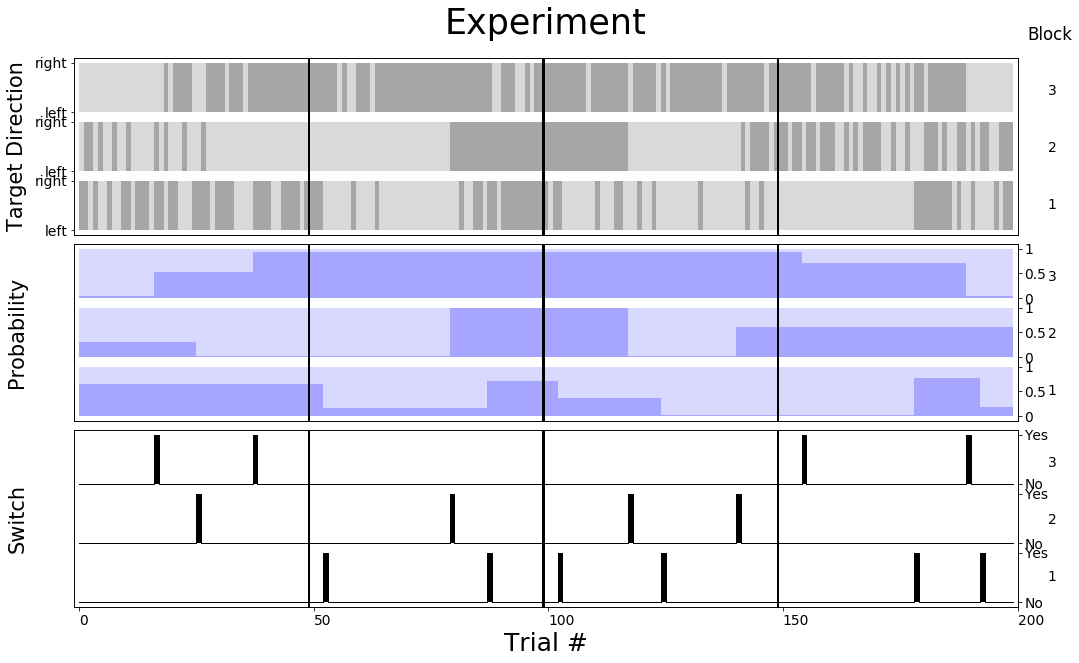

In [21]:
fig, axs = e.plot_experiment(color=[['k', 'k'], ['b', 'b'], ['k','none']])